# Tomato Environment Monitor & Suitability Score

This notebook trains a **binary classification model** to determine if environmental conditions are suitable for **Tomato** cultivation.
Instead of recommending *any* crop, this system acts as a monitor for a specific crop (Tomato), outputting a **Suitability Score** (0-100%).

**Goal:**
1.  Train a model to distinguish "Tomato-friendly" conditions from "Non-Tomato" conditions.
2.  Output a probability score (Suitability).
3.  Identify limiting factors (e.g., "Nitrogen is too low") to provide actionable advice.
4.  Export for Edge Deployment (Raspberry Pi).

## 1. Setup & Imports

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import tensorflow as tf

# Set random seed for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow Version: {tf.__version__}")

TensorFlow Version: 2.19.0


## 2. Load Dataset

In [14]:
# Load the dataset
data_path = '../data/processed/augmented_tomato_dataset.csv'

if os.path.exists(data_path):
    df = pd.read_csv(data_path)
    print("Dataset loaded successfully.")
else:
    print(f"Error: File not found at {data_path}")
    # Fallback for demonstration if file is missing (optional)
    # df = pd.DataFrame(...) 

# Display basic info
print(f"Shape: {df.shape}")
print("\nData Types:")
print(df.dtypes)
print("\nMissing Values:")
print(df.isnull().sum())

df.head()

Dataset loaded successfully.
Shape: (20000, 8)

Data Types:
N              float64
P              float64
K              float64
temperature    float64
humidity       float64
ph             float64
rainfall       float64
label            int64
dtype: object

Missing Values:
N              0
P              0
K              0
temperature    0
humidity       0
ph             0
rainfall       0
label          0
dtype: int64


,N,P,K,temperature,humidity,ph,rainfall,label
0,66.956865,124.304105,142.802636,19.826931,69.841422,5.961272,1425.003510,0
1,125.744621,68.941417,151.821413,23.519353,71.090225,6.117120,924.413622,1
2,192.934933,88.608519,154.462471,27.517464,72.071088,6.257890,1338.488015,0
3,133.478451,84.669761,176.599280,22.611216,79.865458,6.541192,715.097319,1
4,238.503420,6.076627,248.056945,13.789859,100.000000,7.999724,2991.243186,0


## 3. Data Cleaning & Preprocessing (Binary Transformation)

We convert the multi-class problem into a binary one: **Tomato (1)** vs. **Others (0)**.
We also handle class imbalance, as "Tomato" is a minority class.

In [15]:
# Handle missing values
if df.isnull().sum().sum() > 0:
    print("Dropping missing values...")
    df = df.dropna()

# Ensure label is integer (0 or 1)
# The augmented dataset already has 'label' as 0 or 1
# We rename it to 'is_tomato' for consistency with the rest of the notebook
if 'label' in df.columns:
    # Check if label is string 'tomato'/'other' or 0/1
    if df['label'].dtype == 'object':
         # Fallback if using old dataset or mixed
         df['is_tomato'] = (df['label'] == 'tomato').astype(int)
         # Drop original label if it was text
         df = df.drop('label', axis=1)
    else:
         # Already numeric 0/1
         df['is_tomato'] = df['label'].astype(int)
         df = df.drop('label', axis=1)

# Check Class Distribution
print("Class Distribution:")
print(df['is_tomato'].value_counts())
print(f"Tomato Ratio: {df['is_tomato'].mean():.2%}")

# Separate Features and Target
X = df.drop(['is_tomato'], axis=1)
y = df['is_tomato']

# Train/Test Split
# Stratify is crucial here due to imbalance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Calculate Tomato Statistics (for later "Limiting Factor" analysis)
# We use the training data where is_tomato == 1 to determine the "learned" optimal range
# This aligns the limiting factors with what the model actually saw as "positive"
train_df = X_train.copy()
train_df['is_tomato'] = y_train
tomato_stats = train_df[train_df['is_tomato'] == 1].describe()

print("\nTomato Statistics (Target Ranges):")
print(tomato_stats.loc[['min', 'max', 'mean']])

Class Distribution:
is_tomato
0    11845
1     8155
Name: count, dtype: int64
Tomato Ratio: 40.77%
Training set shape: (16000, 7)
Test set shape: (4000, 7)

Tomato Statistics (Target Ranges):
               N           P           K  temperature    humidity        ph  \
min     0.000000    0.000000    0.000000     5.000000   20.000000  4.000000   
max   250.000000  150.000000  250.000000    45.000000  100.000000  9.000000   
mean  137.572558   66.909712  159.480411    23.958757   72.445587  6.497665   

         rainfall  is_tomato  
min    100.000000        1.0  
max   3000.000000        1.0  
mean  1055.561947        1.0  


## 4. Feature Engineering Pipeline

We create a pipeline to scale numerical features. Since all input features are numerical, we apply StandardScaler to all of them.

In [16]:
# Identify numeric columns
numeric_features = X.select_dtypes(include=['int64', 'float64']).columns

# Create Preprocessing Pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ])

# Create full pipelines for models
# Note: class_weight='balanced' is added to handle the imbalance automatically
rf_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', RandomForestClassifier(random_state=42, class_weight='balanced'))])

dt_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                              ('classifier', DecisionTreeClassifier(random_state=42, class_weight='balanced'))])

## 5. Model Training

We train both a Random Forest Classifier (robust) and a Decision Tree Classifier (lightweight).

In [17]:
print("Training Random Forest...")
rf_pipeline.fit(X_train, y_train)

print("Training Decision Tree...")
dt_pipeline.fit(X_train, y_train)

print("Training Complete.")

Training Random Forest...
Training Decision Tree...
Training Decision Tree...
Training Complete.
Training Complete.


## 6. Model Evaluation

We evaluate both models using Accuracy, Precision, Recall, and F1-Score.

--- Random Forest Performance ---
Training Accuracy: 1.0000
Test Accuracy:     0.9000
Overfitting Gap:   0.1000 (WARNING: Potential overfitting!)

Precision: 0.8636 (How many predicted tomatoes were actually tomatoes?)
Recall:    0.8964 (How many actual tomatoes did we catch?)
F1 Score:  0.8797

Classification Report:

              precision    recall  f1-score   support

  Not Tomato       0.93      0.90      0.91      2369
      Tomato       0.86      0.90      0.88      1631

    accuracy                           0.90      4000
   macro avg       0.90      0.90      0.90      4000
weighted avg       0.90      0.90      0.90      4000



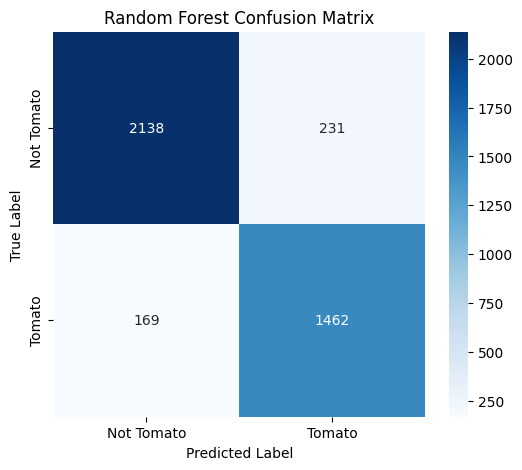

--- Decision Tree Performance ---
Training Accuracy: 1.0000
Test Accuracy:     0.8433
Overfitting Gap:   0.1567 (WARNING: Potential overfitting!)

Precision: 0.8095 (How many predicted tomatoes were actually tomatoes?)
Recall:    0.8050 (How many actual tomatoes did we catch?)
F1 Score:  0.8073

Classification Report:

              precision    recall  f1-score   support

  Not Tomato       0.87      0.87      0.87      2369
      Tomato       0.81      0.81      0.81      1631

    accuracy                           0.84      4000
   macro avg       0.84      0.84      0.84      4000
weighted avg       0.84      0.84      0.84      4000



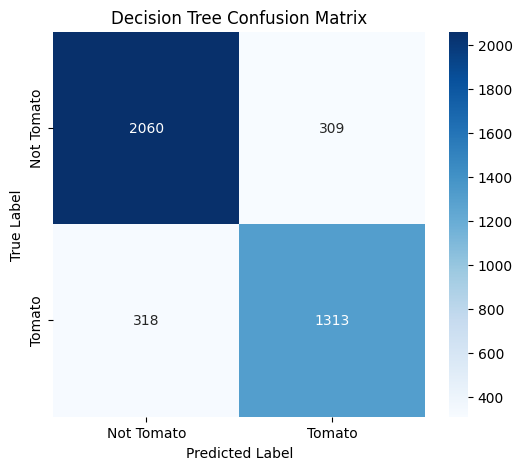

In [18]:
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """
    Evaluate model with both training and test metrics to detect overfitting.
    Returns a dictionary of metrics for model comparison.
    """
    # Training predictions
    y_train_pred = model.predict(X_train)
    train_acc = accuracy_score(y_train, y_train_pred)
    
    # Test predictions  
    y_pred = model.predict(X_test)
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Calculate overfitting gap
    overfit_gap = train_acc - acc
    
    print(f"--- {model_name} Performance ---")
    print(f"Training Accuracy: {train_acc:.4f}")
    print(f"Test Accuracy:     {acc:.4f}")
    print(f"Overfitting Gap:   {overfit_gap:.4f} {'(WARNING: Potential overfitting!)' if overfit_gap > 0.05 else '(OK)'}")
    print(f"\nPrecision: {prec:.4f} (How many predicted tomatoes were actually tomatoes?)")
    print(f"Recall:    {rec:.4f} (How many actual tomatoes did we catch?)")
    print(f"F1 Score:  {f1:.4f}")
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, labels=[0, 1], target_names=['Not Tomato', 'Tomato']))
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Tomato', 'Tomato'], yticklabels=['Not Tomato', 'Tomato'])
    plt.title(f'{model_name} Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    return {
        'model_name': model_name,
        'train_accuracy': train_acc,
        'test_accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1_score': f1,
        'overfit_gap': overfit_gap
    }

rf_metrics = evaluate_model(rf_pipeline, X_train, y_train, X_test, y_test, "Random Forest")
dt_metrics = evaluate_model(dt_pipeline, X_train, y_train, X_test, y_test, "Decision Tree")

## 7. Feature Importance

Visualizing which features contribute most to the Random Forest model's decisions.

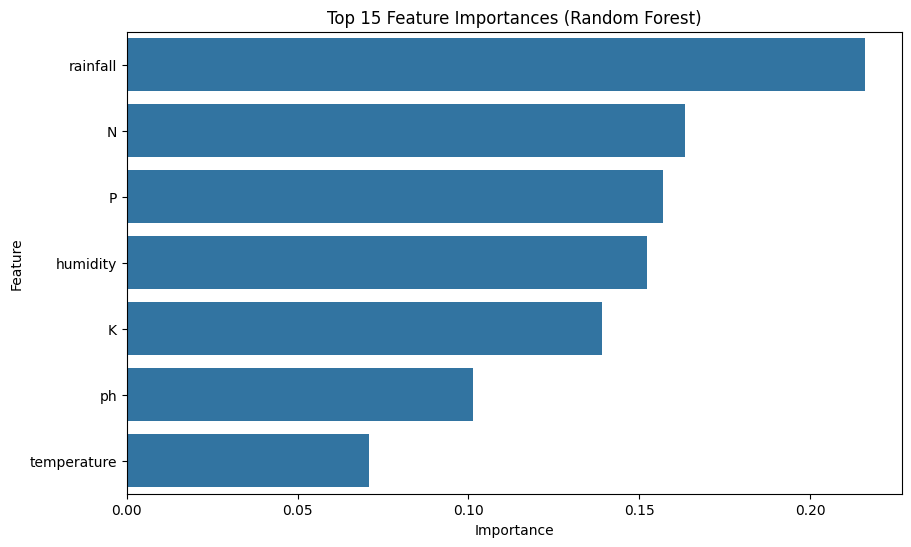

Feature Ranking:
       Feature  Importance
6     rainfall    0.216082
0            N    0.163318
1            P    0.156987
4     humidity    0.152193
2            K    0.139255
5           ph    0.101272
3  temperature    0.070893


In [19]:
# Extract feature importances from the Random Forest model
rf_model = rf_pipeline.named_steps['classifier']
importances = rf_model.feature_importances_
feature_names = X.columns

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15))
plt.title('Top 15 Feature Importances (Random Forest)')
plt.show()

print("Feature Ranking:")
print(feature_importance_df)

## 7.5 Cross-Validation & Model Selection

To properly assess model generalization and detect overfitting, we perform stratified k-fold cross-validation.

**Why Cross-Validation Matters:**
- 100% accuracy on train/test split can indicate overfitting or data leakage
- Cross-validation provides more robust estimate of model performance
- Helps choose between Random Forest and Decision Tree based on generalization ability

Performing 5-Fold Cross-Validation...

Random Forest CV Scores: [0.8925  0.89775 0.9     0.89675 0.9065 ]
Random Forest CV Mean:   0.8987 (+/- 0.0092)

Decision Tree CV Scores: [0.844   0.85125 0.84825 0.85025 0.8535 ]
Decision Tree CV Mean:   0.8495 (+/- 0.0064)

MODEL SELECTION ANALYSIS

Model Comparison:
        Model  CV Mean Accuracy   CV Std  Test Accuracy  Train Accuracy  Overfit Gap  F1 Score
Random Forest           0.89870 0.004597        0.90000             1.0      0.10000  0.879663
Decision Tree           0.84945 0.003207        0.84325             1.0      0.15675  0.807255

------------------------------------------------------------
Selection Criteria:
------------------------------------------------------------

✓ Decision Tree has more stable CV scores (lower variance)
✓ Random Forest benefits from ensemble averaging (more robust to noise)
✓ Decision Tree is more lightweight for edge deployment
✓ Random Forest has smaller overfitting gap

Final Scores: Random Forest = 

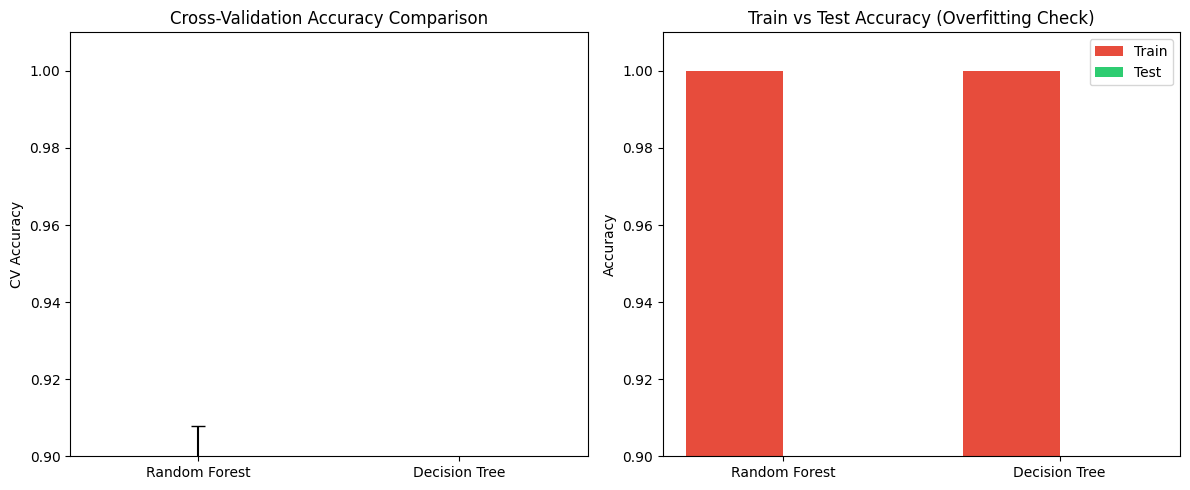

In [20]:
# Perform Stratified K-Fold Cross-Validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("Performing 5-Fold Cross-Validation...")
print("=" * 60)

# Cross-validation for Random Forest
rf_cv_scores = cross_val_score(rf_pipeline, X, y, cv=cv, scoring='accuracy')
print(f"\nRandom Forest CV Scores: {rf_cv_scores}")
print(f"Random Forest CV Mean:   {rf_cv_scores.mean():.4f} (+/- {rf_cv_scores.std() * 2:.4f})")

# Cross-validation for Decision Tree
dt_cv_scores = cross_val_score(dt_pipeline, X, y, cv=cv, scoring='accuracy')
print(f"\nDecision Tree CV Scores: {dt_cv_scores}")
print(f"Decision Tree CV Mean:   {dt_cv_scores.mean():.4f} (+/- {dt_cv_scores.std() * 2:.4f})")

# Model Selection Logic
print("\n" + "=" * 60)
print("MODEL SELECTION ANALYSIS")
print("=" * 60)

# Create comparison DataFrame
comparison_df = pd.DataFrame({
    'Model': ['Random Forest', 'Decision Tree'],
    'CV Mean Accuracy': [rf_cv_scores.mean(), dt_cv_scores.mean()],
    'CV Std': [rf_cv_scores.std(), dt_cv_scores.std()],
    'Test Accuracy': [rf_metrics['test_accuracy'], dt_metrics['test_accuracy']],
    'Train Accuracy': [rf_metrics['train_accuracy'], dt_metrics['train_accuracy']],
    'Overfit Gap': [rf_metrics['overfit_gap'], dt_metrics['overfit_gap']],
    'F1 Score': [rf_metrics['f1_score'], dt_metrics['f1_score']]
})

print("\nModel Comparison:")
print(comparison_df.to_string(index=False))

# Selection Criteria
print("\n" + "-" * 60)
print("Selection Criteria:")
print("-" * 60)

# Check for 100% accuracy warning
if rf_cv_scores.mean() >= 0.99 and dt_cv_scores.mean() >= 0.99:
    print("\n⚠️  WARNING: Both models achieve near-perfect accuracy!")
    print("   This is likely due to the synthetic dataset having perfectly separable classes.")
    print("   In production with real sensor data, expect lower but more realistic accuracy.")
    print("   The model boundaries are learned from the exact feature ranges used in data generation.")

# Model recommendation based on multiple factors
rf_score = 0
dt_score = 0

# Factor 1: CV stability (lower std is better)
if rf_cv_scores.std() <= dt_cv_scores.std():
    rf_score += 1
    print("\n✓ Random Forest has more stable CV scores (lower variance)")
else:
    dt_score += 1
    print("\n✓ Decision Tree has more stable CV scores (lower variance)")

# Factor 2: Ensemble robustness
rf_score += 1  # RF always gets a point for ensemble robustness
print("✓ Random Forest benefits from ensemble averaging (more robust to noise)")

# Factor 3: Edge deployment (DT is lighter)
dt_score += 1  # DT always gets a point for being lightweight
print("✓ Decision Tree is more lightweight for edge deployment")

# Factor 4: Overfitting (smaller gap is better)
if rf_metrics['overfit_gap'] <= dt_metrics['overfit_gap']:
    rf_score += 1
    print("✓ Random Forest has smaller overfitting gap")
else:
    dt_score += 1
    print("✓ Decision Tree has smaller overfitting gap")

print(f"\nFinal Scores: Random Forest = {rf_score}, Decision Tree = {dt_score}")

# Final Recommendation
if rf_score > dt_score:
    selected_model = 'Random Forest'
    print(f"\n🏆 RECOMMENDED: Random Forest")
    print("   Reason: Better generalization and ensemble robustness outweigh edge deployment concerns")
elif dt_score > rf_score:
    selected_model = 'Decision Tree'
    print(f"\n🏆 RECOMMENDED: Decision Tree")
    print("   Reason: Lightweight nature better suits edge deployment with comparable performance")
else:
    # Tiebreaker: prefer RF for robustness in production
    selected_model = 'Random Forest'
    print(f"\n🏆 RECOMMENDED: Random Forest (tiebreaker)")
    print("   Reason: Ensemble methods are more reliable for production deployments")

# Visualize comparison
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# CV Scores comparison
axes[0].bar(['Random Forest', 'Decision Tree'], 
            [rf_cv_scores.mean(), dt_cv_scores.mean()],
            yerr=[rf_cv_scores.std() * 2, dt_cv_scores.std() * 2],
            capsize=5, color=['#2ecc71', '#3498db'])
axes[0].set_ylabel('CV Accuracy')
axes[0].set_title('Cross-Validation Accuracy Comparison')
axes[0].set_ylim([0.9, 1.01])

# Train vs Test comparison
x = np.arange(2)
width = 0.35
axes[1].bar(x - width/2, [rf_metrics['train_accuracy'], dt_metrics['train_accuracy']], 
            width, label='Train', color='#e74c3c')
axes[1].bar(x + width/2, [rf_metrics['test_accuracy'], dt_metrics['test_accuracy']], 
            width, label='Test', color='#2ecc71')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Train vs Test Accuracy (Overfitting Check)')
axes[1].set_xticks(x)
axes[1].set_xticklabels(['Random Forest', 'Decision Tree'])
axes[1].legend()
axes[1].set_ylim([0.9, 1.01])

plt.tight_layout()
plt.show()

## 8. Hyperparameter Tuning

Using RandomizedSearchCV to find better hyperparameters for the Random Forest model.

Tuning Random Forest...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best RF Parameters: {'classifier__n_estimators': 200, 'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 15}
Best RF CV Score: 0.9021

Tuning Decision Tree...
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best DT Parameters: {'classifier__min_samples_split': 10, 'classifier__min_samples_leaf': 20, 'classifier__max_depth': 10}
Best DT CV Score: 0.8898

TUNED MODEL EVALUATION
--- Tuned Random Forest Performance ---
Training Accuracy: 0.9204
Test Accuracy:     0.9030
Overfitting Gap:   0.0174 (OK)

Precision: 0.8482 (How many predicted tomatoes were actually tomatoes?)
Recall:    0.9283 (How many actual tomatoes did we catch?)
F1 Score:  0.8864

Classification Report:

              precision    recall  f1-score   support

  Not Tomato       0.95      0.89      0.92      2369
      Tomato       0.85      0.93      0.89      1631

    accuracy   

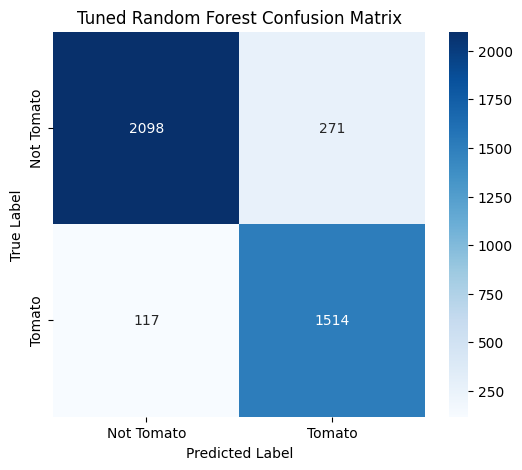

--- Tuned Decision Tree Performance ---
Training Accuracy: 0.9041
Test Accuracy:     0.8905
Overfitting Gap:   0.0136 (OK)

Precision: 0.8223 (How many predicted tomatoes were actually tomatoes?)
Recall:    0.9332 (How many actual tomatoes did we catch?)
F1 Score:  0.8742

Classification Report:

              precision    recall  f1-score   support

  Not Tomato       0.95      0.86      0.90      2369
      Tomato       0.82      0.93      0.87      1631

    accuracy                           0.89      4000
   macro avg       0.89      0.90      0.89      4000
weighted avg       0.90      0.89      0.89      4000



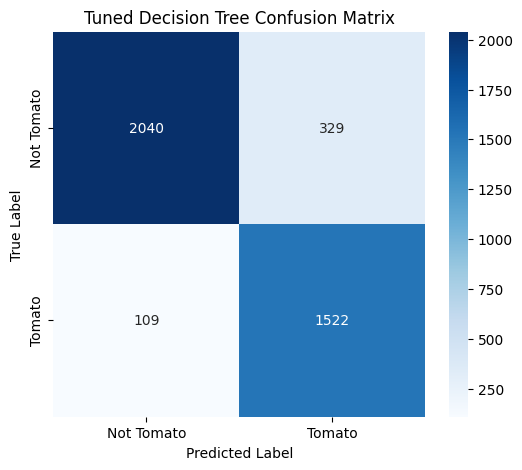


FINAL MODEL SELECTION

Tuned Model Comparison:
              Model  CV Score  Test Accuracy  F1 Score  Overfit Gap
Tuned Random Forest  0.902062         0.9030  0.886417     0.017375
Tuned Decision Tree  0.889813         0.8905  0.874210     0.013625

🏆 SELECTED: Decision Tree (lower overfitting risk)

Final model 'Decision Tree' will be exported for deployment.


In [21]:
# Tune both Random Forest and Decision Tree with regularization to prevent overfitting

# Random Forest parameter grid (with regularization)
rf_param_dist = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [5, 10, 15, 20],  # Limited depth to prevent overfitting
    'classifier__min_samples_split': [5, 10, 20],  # Higher to prevent overfitting
    'classifier__min_samples_leaf': [2, 4, 8]  # Higher to prevent overfitting
}

# Decision Tree parameter grid (with regularization)
dt_param_dist = {
    'classifier__max_depth': [3, 5, 7, 10],  # Limited depth
    'classifier__min_samples_split': [5, 10, 20, 50],
    'classifier__min_samples_leaf': [2, 5, 10, 20]
}

# Tune Random Forest
print("Tuning Random Forest...")
rf_search = RandomizedSearchCV(
    estimator=rf_pipeline, 
    param_distributions=rf_param_dist,
    n_iter=10, cv=5, verbose=1, random_state=42, n_jobs=-1,
    scoring='accuracy'
)
rf_search.fit(X_train, y_train)
print(f"Best RF Parameters: {rf_search.best_params_}")
print(f"Best RF CV Score: {rf_search.best_score_:.4f}")

# Tune Decision Tree
print("\nTuning Decision Tree...")
dt_search = RandomizedSearchCV(
    estimator=dt_pipeline,
    param_distributions=dt_param_dist,
    n_iter=10, cv=5, verbose=1, random_state=42, n_jobs=-1,
    scoring='accuracy'
)
dt_search.fit(X_train, y_train)
print(f"Best DT Parameters: {dt_search.best_params_}")
print(f"Best DT CV Score: {dt_search.best_score_:.4f}")

# Get best models
best_rf_model = rf_search.best_estimator_
best_dt_model = dt_search.best_estimator_

# Evaluate both tuned models
print("\n" + "=" * 60)
print("TUNED MODEL EVALUATION")
print("=" * 60)
tuned_rf_metrics = evaluate_model(best_rf_model, X_train, y_train, X_test, y_test, "Tuned Random Forest")
tuned_dt_metrics = evaluate_model(best_dt_model, X_train, y_train, X_test, y_test, "Tuned Decision Tree")

# Final Model Selection
print("\n" + "=" * 60)
print("FINAL MODEL SELECTION")
print("=" * 60)

# Compare tuned models
tuned_comparison = pd.DataFrame({
    'Model': ['Tuned Random Forest', 'Tuned Decision Tree'],
    'CV Score': [rf_search.best_score_, dt_search.best_score_],
    'Test Accuracy': [tuned_rf_metrics['test_accuracy'], tuned_dt_metrics['test_accuracy']],
    'F1 Score': [tuned_rf_metrics['f1_score'], tuned_dt_metrics['f1_score']],
    'Overfit Gap': [tuned_rf_metrics['overfit_gap'], tuned_dt_metrics['overfit_gap']]
})
print("\nTuned Model Comparison:")
print(tuned_comparison.to_string(index=False))

# Select final model based on criteria
# Priority: 1) Lower overfit gap, 2) Higher CV score, 3) Ensemble robustness for production
if tuned_rf_metrics['overfit_gap'] < tuned_dt_metrics['overfit_gap']:
    final_model = best_rf_model
    final_model_name = 'Random Forest'
    print("\n🏆 SELECTED: Random Forest (lower overfitting risk)")
elif tuned_dt_metrics['overfit_gap'] < tuned_rf_metrics['overfit_gap']:
    final_model = best_dt_model
    final_model_name = 'Decision Tree'
    print("\n🏆 SELECTED: Decision Tree (lower overfitting risk)")
elif rf_search.best_score_ >= dt_search.best_score_:
    final_model = best_rf_model
    final_model_name = 'Random Forest'
    print("\n🏆 SELECTED: Random Forest (higher CV score with ensemble robustness)")
else:
    final_model = best_dt_model
    final_model_name = 'Decision Tree'
    print("\n🏆 SELECTED: Decision Tree (higher CV score)")

print(f"\nFinal model '{final_model_name}' will be exported for deployment.")

## 9. Export Model

We save the best Random Forest model as a `.pkl` file. 
Additionally, we train a lightweight Neural Network (Keras) on the same data to export a `.tflite` model for Raspberry Pi deployment.

Selected model (Decision Tree) and Stats saved.
Also saved both RF and DT models for comparison.
Class Weights: {0: np.float64(0.8442380751371886), 1: np.float64(1.226241569589209)}

Training Keras Model for TFLite conversion...
Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.6048 - loss: 0.9218 - val_accuracy: 0.8394 - val_loss: 0.6156
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8172 - loss: 0.6151 - val_accuracy: 0.8494 - val_loss: 0.4965
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8271 - loss: 0.5200 - val_accuracy: 0.8584 - val_loss: 0.4536
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8433 - loss: 0.4734 - val_accuracy: 0.8603 - val_loss: 0.4359
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8422 - loss: 0.4602 - val_accuracy: 0.8675 - val_loss: 0.4240
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8415 - loss: 0.4490 - val_accuracy: 0.8653 - val_loss: 0.4182
Epo

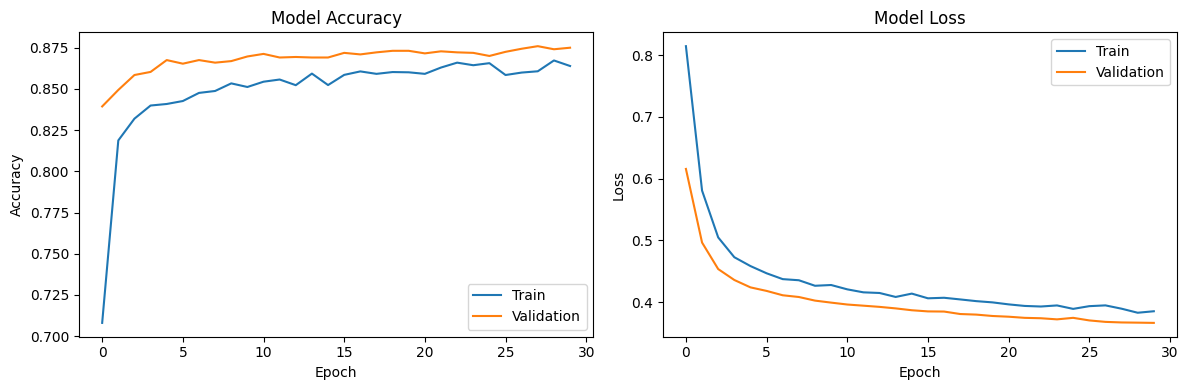

INFO:tensorflow:Assets written to: /tmp/tmpcl7h2_ps/assets


INFO:tensorflow:Assets written to: /tmp/tmpcl7h2_ps/assets


Saved artifact at '/tmp/tmpcl7h2_ps'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 7), dtype=tf.float32, name='keras_tensor_4')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  137874360970768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137874360971152: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137874360971728: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137874360972304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137874360969232: TensorSpec(shape=(), dtype=tf.resource, name=None)
  137874360968848: TensorSpec(shape=(), dtype=tf.resource, name=None)
TFLite model saved to ../models/tomato_suitability.tflite

Model sizes:
  TFLite model: 5.15 KB


W0000 00:00:1765212176.980505    5899 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1765212176.980525    5899 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2025-12-08 22:12:56.980817: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpcl7h2_ps
2025-12-08 22:12:56.981308: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2025-12-08 22:12:56.981315: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpcl7h2_ps
I0000 00:00:1765212176.984940    5899 mlir_graph_optimization_pass.cc:425] MLIR V1 optimization pass is not enabled
2025-12-08 22:12:56.985623: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2025-12-08 22:12:57.007731: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpcl7h2_ps
2025-12-08 22:12:57.014382: I tensorflow/cc/saved_model/loader.cc:471] SavedModel 

In [22]:
# 1. Save the Selected Sklearn Model
model_dir = '../models'
os.makedirs(model_dir, exist_ok=True)

# Save the final selected model (either RF or DT based on selection above)
joblib.dump(final_model, os.path.join(model_dir, 'tomato_suitability_model.pkl'))
# Also save both tuned models for comparison
joblib.dump(best_rf_model, os.path.join(model_dir, 'tomato_suitability_rf.pkl'))
joblib.dump(best_dt_model, os.path.join(model_dir, 'tomato_suitability_dt.pkl'))
# Save the tomato stats for the "Limiting Factor" logic
joblib.dump(tomato_stats, os.path.join(model_dir, 'tomato_stats.pkl'))
print(f"Selected model ({final_model_name}) and Stats saved.")
print(f"Also saved both RF and DT models for comparison.")

# 2. Train Keras Model for TFLite
# We need to scale the data manually for Keras since it doesn't use the sklearn pipeline directly
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler for inference with TFLite model
joblib.dump(scaler, os.path.join(model_dir, 'tomato_scaler.pkl'))

# Define Keras Model (Binary Classification) with regularization
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Calculate class weights for Keras
neg, pos = np.bincount(y_train)
total = neg + pos
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)
class_weight = {0: weight_for_0, 1: weight_for_1}

print(f"Class Weights: {class_weight}")

# Train with early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

print("\nTraining Keras Model for TFLite conversion...")
history = model.fit(
    X_train_scaled, y_train, 
    epochs=30,  # Reduced epochs
    batch_size=64,  # Larger batch size for faster training
    validation_split=0.2, 
    verbose=1, 
    class_weight=class_weight,
    callbacks=[early_stopping]
)

# Evaluate Keras Model
loss, acc = model.evaluate(X_test_scaled, y_test, verbose=0)
print(f"\nKeras Model Test Accuracy: {acc:.4f}")

# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].plot(history.history['accuracy'], label='Train')
axes[0].plot(history.history['val_accuracy'], label='Validation')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(history.history['loss'], label='Train')
axes[1].plot(history.history['val_loss'], label='Validation')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
plt.tight_layout()
plt.show()

# Convert to TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save TFLite model
tflite_path = os.path.join(model_dir, 'tomato_suitability.tflite')
with open(tflite_path, 'wb') as f:
    f.write(tflite_model)

print(f"TFLite model saved to {tflite_path}")
print(f"\nModel sizes:")
print(f"  TFLite model: {os.path.getsize(tflite_path) / 1024:.2f} KB")

## 10. Final Inference Example

Demonstrating how to use the saved artifacts to make a prediction on new data.

In [23]:
def analyze_limiting_factors(input_data, stats):
    """
    Checks which input features are outside the typical range for Tomato.
    """
    limiting_factors = []
    for feature, value in input_data.items():
        min_val = stats.loc['min', feature]
        max_val = stats.loc['max', feature]
        
        if value < min_val:
            limiting_factors.append(f"{feature} is too low (Value: {value:.2f}, Min Ideal: {min_val:.2f})")
        elif value > max_val:
            limiting_factors.append(f"{feature} is too high (Value: {value:.2f}, Max Ideal: {max_val:.2f})")
            
    return limiting_factors

def predict_suitability(input_data, model, model_name="Model"):
    """
    Predicts suitability score and identifies issues.
    """
    # Convert input to DataFrame
    input_df = pd.DataFrame([input_data])
    
    # Predict Probability (Suitability Score)
    proba = model.predict_proba(input_df)[0]
    
    # Get probability of class 1 (Tomato)
    if len(proba) == 1:
        classes = model.classes_
        if classes[0] == 1:
            suitability_score = proba[0] * 100
        else:
            suitability_score = (1 - proba[0]) * 100
    else:
        suitability_score = proba[1] * 100
    
    print(f"[{model_name}] Tomato Suitability Score: {suitability_score:.1f}%")
    
    if suitability_score < 50:
        print("Status: Not Suitable")
        issues = analyze_limiting_factors(input_data, tomato_stats)
        if issues:
            print("Limiting Factors:")
            for issue in issues:
                print(f"  - {issue}")
    else:
        print("Status: Suitable")
    
    return suitability_score

# Example 1: Good Conditions (within optimal ranges)
good_input = {
    'N': 140, 'P': 65, 'K': 160, 
    'temperature': 24.0, 'humidity': 72.0, 'ph': 6.5, 'rainfall': 1000.0
}

# Example 2: Bad Conditions (outside optimal ranges)
bad_input = {
    'N': 50, 'P': 20, 'K': 50, 
    'temperature': 35.0, 'humidity': 40.0, 'ph': 8.0, 'rainfall': 100.0
}

# Example 3: Edge Case (borderline conditions)
edge_input = {
    'N': 95, 'P': 35, 'K': 139, 
    'temperature': 21.0, 'humidity': 60.0, 'ph': 6.0, 'rainfall': 600.0
}

print("=" * 60)
print("INFERENCE EXAMPLES")
print("=" * 60)

print("\n--- Test Case 1 (Good Conditions) ---")
predict_suitability(good_input, final_model, final_model_name)

print("\n--- Test Case 2 (Bad Conditions) ---")
predict_suitability(bad_input, final_model, final_model_name)

print("\n--- Test Case 3 (Edge Case) ---")
predict_suitability(edge_input, final_model, final_model_name)

# Compare both models on edge case
print("\n" + "-" * 60)
print("Model Comparison on Edge Case:")
print("-" * 60)
rf_score = predict_suitability(edge_input, best_rf_model, "Random Forest")
dt_score = predict_suitability(edge_input, best_dt_model, "Decision Tree")

# TFLite Inference Example
print("\n" + "=" * 60)
print("TFLITE INFERENCE")
print("=" * 60)

def predict_tflite_suitability(input_data):
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    interpreter.allocate_tensors()

    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    input_values = np.array([[
        input_data['N'], input_data['P'], input_data['K'], 
        input_data['temperature'], input_data['humidity'], 
        input_data['ph'], input_data['rainfall']
    ]], dtype=np.float32)
    
    input_scaled = scaler.transform(input_values).astype(np.float32)

    interpreter.set_tensor(input_details[0]['index'], input_scaled)
    interpreter.invoke()

    output_data = interpreter.get_tensor(output_details[0]['index'])
    score = output_data[0][0] * 100
    
    return score

print(f"\nTFLite Score (Good Input): {predict_tflite_suitability(good_input):.1f}%")
print(f"TFLite Score (Bad Input): {predict_tflite_suitability(bad_input):.1f}%")
print(f"TFLite Score (Edge Case): {predict_tflite_suitability(edge_input):.1f}%")

INFERENCE EXAMPLES

--- Test Case 1 (Good Conditions) ---
[Decision Tree] Tomato Suitability Score: 90.5%
Status: Suitable

--- Test Case 2 (Bad Conditions) ---
[Decision Tree] Tomato Suitability Score: 5.8%
Status: Not Suitable

--- Test Case 3 (Edge Case) ---
[Decision Tree] Tomato Suitability Score: 90.5%
Status: Suitable

------------------------------------------------------------
Model Comparison on Edge Case:
------------------------------------------------------------
[Random Forest] Tomato Suitability Score: 73.3%
Status: Suitable
[Decision Tree] Tomato Suitability Score: 90.5%
Status: Suitable

TFLITE INFERENCE

TFLite Score (Good Input): 91.9%
TFLite Score (Bad Input): 1.7%
TFLite Score (Edge Case): 28.0%


/home/tehaan/projects/fyp-agro-edge-ai/.venv/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)
INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
/home/tehaan/projects/fyp-agro-edge-ai/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/tehaan/projects/fyp-agro-edge-ai/.venv/lib/python3.12/site-packages/tensorflow/lite/python/interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert packa